# NYCU Machine Learning 2024 : HW4 SVM


In [44]:
from itertools import combinations
from dataclasses import dataclass, field

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from rich import print
from tqdm import tqdm
import seaborn as sns

from lib import SupportVectorMachine, IrisDataset

In [11]:
np.set_printoptions(precision=4)

In [12]:
df = IrisDataset.load_iris_file(with_name=True)
df

,Sepal length,Sepal width,Petal length,Petal width,Label
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [13]:
@dataclass
class SvmModelModule:
    pair: tuple[str,str]
    model: SupportVectorMachine
    positive_class:str
    negative_class:str
    
    # for mapping
    label_to_index_np : np.vectorize = field(repr=False)
    index_to_label_np : np.vectorize = field(repr=False)
    
    @classmethod
    def build(cls, pair:tuple[str,str], C:int, kernel_name: str , kernel_arg: dict , threshold: float):
        positive_class, negative_class = pair
        model = SupportVectorMachine(
            C=C , 
            kernel_name=kernel_name,
            kernel_arg=kernel_arg,
            threshold=threshold,
        )
        
        label_to_index = {positive_class : 1 , negative_class : -1}
        index_to_label = {1 : positive_class ,0: "idk", -1 : negative_class}


        label_to_index_np = np.vectorize(label_to_index.get)
        index_to_label_np = np.vectorize(index_to_label.get)
        
        return cls(
            pair, 
            model, 
            positive_class, 
            negative_class, 
            label_to_index_np, 
            index_to_label_np
        )
        
    def build_train_test_dataset(self, df_in:pd.DataFrame, train_size:int=IrisDataset.TRAIN_DATA_SIZE):
        # have before and after -> for two-fold 
        positive_data = df_in[df_in["Label"] == self.positive_class]
        negative_data = df_in[df_in["Label"] == self.negative_class]
        
        before = [positive_data[:train_size], negative_data[:train_size]]
        after  = [positive_data[train_size:], negative_data[train_size:]]
        
        return {
            "before": {
                "train": pd.concat(before),
                "test" : pd.concat(after),
            },
            "after" : {
                "train" : pd.concat(after),
                "test"  : pd.concat(before),
            }
        }
    
    
    def build_for_model_input(self, df_in:pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
        in_x , in_y = df_in.drop(columns=["Label"]).to_numpy() , df_in["Label"].to_numpy() 
        
        in_y = self.label_to_index_np(in_y)
        return in_x , in_y
    
    # need to cut the data
    def train(self , df_in :pd.DataFrame):
        x,y = self.build_for_model_input(df_in=df_in)
        
        self.model.train(x, y)
        return 
    
    # for the analysis
    def acc(self, df_in :pd.DataFrame)->float:
        x, y = self.build_for_model_input(df_in=df_in)
        acc = self.model.acc(x, y)
        return acc
    
    def predict(self, x:np.ndarray)->np.ndarray:
        res = self.model(x,with_sign=True)
        
        res_label = self.index_to_label_np(res)
        
        return res_label
    
    

In [ ]:

class MultiSupportVectorMachine:
    
    STATES = ["before", "after"]
    
    def __init__(self,class_names:list[str], C: int, kernel_name: str = "rbf", kernel_arg: dict = dict(), threshold: float = 1e-20):
        self._C = C
        self._kernel_name = kernel_name  
        self._kernel_arg = kernel_arg
        self._threshold = threshold
        self._class_names = class_names
        
        class_combination = list(combinations(class_names, 2))
        
        # build model
        self._models = {
            pair: SvmModelModule.build(
                pair=pair,
                C=self._C , 
                kernel_name=self._kernel_name,
                kernel_arg=self._kernel_arg,
                threshold=self._threshold,
            ) 
            for pair in class_combination
        }
        
        return 
    
    def __repr__(self):
        return f"class name: {self._class_names}, C: {self._C}, kernel: {self._kernel_name} ({self._kernel_arg})"
    
    def train(self, data_in : dict[tuple[str,str], pd.DataFrame])->dict:
        acc_dict = dict()
        
        for pair, training_data in data_in.items():
            self._models[pair].train(training_data)
            
            acc_dict[pair] = self._models[pair].acc(training_data)
        
        
        return acc_dict
    
    def _get_most_freq_by_row(self,row:np.ndarray):
        unique , counts = np.unique(row , return_counts=True)
        return unique[np.argmax(counts)]
    
    def predict(self, x:np.ndarray) -> np.ndarray:
        
        res = [model.predict(x) for model in self._models.values()]
        res_np = np.array(res).T
        res = np.array([self._get_most_freq_by_row(row) for row in res_np])
        return res
    
    def acc(self, df_in: pd.DataFrame) -> tuple[float, np.ndarray]:
        x , y = df_in.drop(columns=["Label"]).to_numpy() , df_in["Label"].to_numpy() 
        res = self.predict(x)
        
        return np.mean(res ==y), res
    
    
    def build_dataset(self, df_in: pd.DataFrame) -> dict:
        dataset = {
            "before" : {"train" : dict(), "test":[]},
            "after" : {"train" : dict(), "test":[]}
        }
        
        # build dataset
        for pair in self._models.keys():
            part_of_dataset = self._models[pair].build_train_test_dataset(df_in)
            
            for state in MultiSupportVectorMachine.STATES:
                dataset[state]["train"][pair] = part_of_dataset[state]["train"]
                dataset[state]["test"].append(part_of_dataset[state]["test"])
        
        # merge to same dataset "test"
        for state in MultiSupportVectorMachine.STATES:
            dataset[state]["test"] = pd.concat(dataset[state]["test"])
            
        return dataset

In [15]:
@dataclass
class TestResult:
    content:dict = field(repr=False)
    model: MultiSupportVectorMachine
    C : int
    sigma : float
    before_acc : float
    after_acc : float
    avg_acc : float
    
    @classmethod
    def build(cls, model:MultiSupportVectorMachine, logs:dict):
        return cls(
            logs, 
            model, 
            model._C, 
            model._kernel_arg["sigma"],
            logs["before"]["acc"],
            logs["after"]["acc"],
            logs["avg_acc"],
        )
        
        
    def to_data_record(self):
        return {
            "C": self.C, 
            "sigma": self.sigma,
            "before_acc":self.before_acc, 
            "after_acc":self.after_acc, 
            "avg_acc": self.avg_acc,
        }

In [16]:
def two_fold_val(model:MultiSupportVectorMachine, df_in:pd.DataFrame):
    dataset = model.build_dataset(df_in)
    result_log = dict()
    
    state_acc = []
    
    for state in MultiSupportVectorMachine.STATES:
        # train
        train_data, test_data = dataset[state]["train"], dataset[state]["test"]
        each_model_training_acc = model.train(train_data)
        
        # test
        acc, predict = model.acc(test_data)
        
        result_log[state] = {
            "each_model_training_acc" : each_model_training_acc,
            "acc" : acc,
            "predict" : predict,
        }
        
        state_acc.append(acc)
    
    result_log["avg_acc"] = np.mean(state_acc)
        
    return TestResult.build(model, result_log) 

In [17]:
def hw_grid_search():
    # 定义参数范围
    c_values = [1, 5, 10, 50, 100, 500, 1000]
    sigma_powers = range(-100, 101, 5)
    
   
    results = []
    result_record = []

    # 遍历所有参数组合，并显示进度条
    for c in tqdm(c_values, desc="Grid Search for C"):
        for sigma_power in sigma_powers:
            sigma = 1.05 ** sigma_power
            model = MultiSupportVectorMachine(
                class_names=IrisDataset.LABEL,
                C=c,
                kernel_name="rbf",
                kernel_arg={"sigma": sigma},
            )
            res = two_fold_val(model, df)
            
            # 将每次结果添加到列表中
            results.append(res)
            result_record.append(res.to_data_record())

    
    result_record = pd.DataFrame(result_record)

    
    max_item = max(results, key=lambda x: x.avg_acc)

    return results, result_record, max_item

In [18]:
results, result_record, max_item = hw_grid_search()

Grid Search for C:   0%|          | 0/7 [00:00<?, ?it/s]

Grid Search for C: 100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


In [22]:
print(max_item)

TestResult(
    model=class name: ['Setosa', 'Versicolor', 'Virginica'], C: 100, kernel: rbf ({'sigma': 1.2762815625000004}),
    C=100,
    sigma=1.2762815625000004,
    before_acc=np.float64(0.9733333333333334),
    after_acc=np.float64(0.9733333333333334),
    avg_acc=np.float64(0.9733333333333334)
)

In [45]:
max_item.to_data_record()

{'C': 100,
 'sigma': 1.2762815625000004,
 'before_acc': np.float64(0.9733333333333334),
 'after_acc': np.float64(0.9733333333333334),
 'avg_acc': np.float64(0.9733333333333334)}

In [39]:
result_record["1.05 power"] =np.rint(np.log(result_record['sigma']) / np.log(1.05)).astype(int)

In [47]:
result_record["avg_acc"] = result_record["avg_acc"]* 100

In [56]:
result_record["avg_acc"]= result_record["avg_acc"].apply(lambda x: f"{x:.2f}")

In [49]:
result_record["before_acc"] = result_record["before_acc"]* 100

In [57]:
result_record["before_acc"]= result_record["before_acc"].apply(lambda x: f"{x:.2f}")

In [50]:
result_record["after_acc"] = result_record["after_acc"]* 100

In [58]:
result_record["after_acc"]= result_record["after_acc"].apply(lambda x: f"{x:.2f}")

In [59]:
result_record

,C,sigma,before_acc,after_acc,avg_acc,1.05 power
0,1,0.007604,53.33,34.67,44.00,-100
1,1,0.009705,36.00,36.00,36.00,-95
2,1,0.012387,62.67,36.00,49.33,-90
3,1,0.015809,40.00,36.00,38.00,-85
4,1,0.020177,42.67,36.00,39.33,-80
...,...,...,...,...,...,...
282,1000,49.561441,94.67,96.00,95.33,80
283,1000,63.254353,94.67,97.33,96.00,85
284,1000,80.730365,94.67,96.00,95.33,90
285,1000,103.034676,94.67,96.00,95.33,95


In [62]:
print(result_record.drop(columns=["sigma"]).to_markdown())

|     |    C |   before_acc |   after_acc |   avg_acc |   1.05 power |
|----:|-----:|-------------:|------------:|----------:|-------------:|
|   0 |    1 |        53.33 |       34.67 |     44    |         -100 |
|   1 |    1 |        36    |       36    |     36    |          -95 |
|   2 |    1 |        62.67 |       36    |     49.33 |          -90 |
|   3 |    1 |        40    |       36    |     38    |          -85 |
|   4 |    1 |        42.67 |       36    |     39.33 |          -80 |
|   5 |    1 |        66.67 |       36    |     51.33 |          -75 |
|   6 |    1 |        46.67 |       36    |     41.33 |          -70 |
|   7 |    1 |        60    |       40    |     50    |          -65 |
|   8 |    1 |        60    |       52    |     56    |          -60 |
|   9 |    1 |        68    |       58.67 |     63.33 |          -55 |
|  10 |    1 |        72    |       60    |     66    |          -50 |
|  11 |    1 |        80    |       69.33 |     74.67 |          -45 |
|  12 |    1 |        89.33 |       81.33 |     85.33 |          -40 |
|  13 |    1 |        92    |       89.33 |     90.67 |          -35 |
|  14 |    1 |        94.67 |       93.33 |     94    |          -30 |
|  15 |    1 |        93.33 |       97.33 |     95.33 |          -25 |
|  16 |    1 |        94.67 |       96    |     95.33 |          -20 |
|  17 |    1 |        94.67 |       96    |     95.33 |          -15 |
|  18 |    1 |        94.67 |       96    |     95.33 |          -10 |
|  19 |    1 |        96    |       96    |     96    |           -5 |
|  20 |    1 |        96    |       96    |     96    |            0 |
|  21 |    1 |        96    |       96    |     96    |            5 |
|  22 |    1 |        94.67 |       97.33 |     96    |           10 |
|  23 |    1 |        94.67 |       96    |     95.33 |           15 |
|  24 |    1 |        93.33 |       94.67 |     94    |           20 |
|  25 |    1 |        92    |       92    |     92    |           25 |
|  26 |    1 |        90.67 |       94.67 |     92.67 |           30 |
|  27 |    1 |        89.33 |       93.33 |     91.33 |           35 |
|  28 |    1 |        89.33 |       93.33 |     91.33 |           40 |
|  29 |    1 |        89.33 |       90.67 |     90    |           45 |
|  30 |    1 |        89.33 |       89.33 |     89.33 |           50 |
|  31 |    1 |        89.33 |       90.67 |     90    |           55 |
|  32 |    1 |        90.67 |       89.33 |     90    |           60 |
|  33 |    1 |        77.33 |       85.33 |     81.33 |           65 |
|  34 |    1 |        70.67 |       82.67 |     76.67 |           70 |
|  35 |    1 |        69.33 |       77.33 |     73.33 |           75 |
|  36 |    1 |        73.33 |       74.67 |     74    |           80 |
|  37 |    1 |        68    |       92    |     80    |           85 |
|  38 |    1 |        66.67 |       92    |     79.33 |           90 |
|  39 |    1 |        94.67 |       92    |     93.33 |           95 |
|  40 |    1 |        94.67 |       92    |     93.33 |          100 |
|  41 |    5 |        53.33 |       45.33 |     49.33 |         -100 |
|  42 |    5 |        64    |       50.67 |     57.33 |          -95 |
|  43 |    5 |        38.67 |       36    |     37.33 |          -90 |
|  44 |    5 |        66.67 |       36    |     51.33 |          -85 |
|  45 |    5 |        66.67 |       36    |     51.33 |          -80 |
|  46 |    5 |        44    |       36    |     40    |          -75 |
|  47 |    5 |        46.67 |       36    |     41.33 |          -70 |
|  48 |    5 |        60    |       40    |     50    |          -65 |
|  49 |    5 |        60    |       52    |     56    |          -60 |
|  50 |    5 |        68    |       58.67 |     63.33 |          -55 |
|  51 |    5 |        72    |       60    |     66    |          -50 |
|  52 |    5 |        80    |       69.33 |     74.67 |          -45 |
|  53 |    5 |        89.33 |       81.33 |     85.33 |          -40 |
|  54 |    5 |        90

In [61]:
result_record.to_csv("multi_class_svm_result.csv", index=False)

## Avg acc

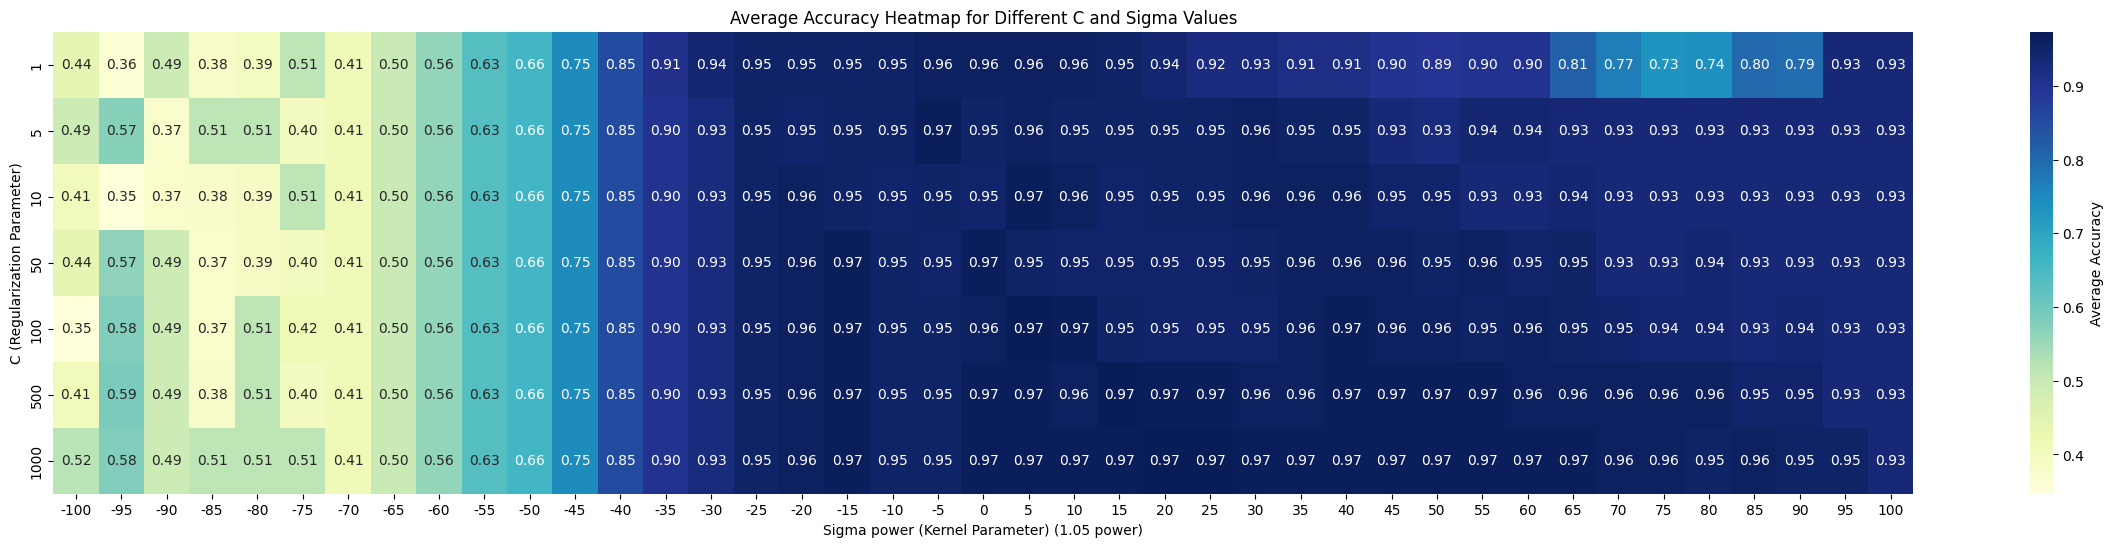

In [41]:
heatmap_data = result_record.pivot(index="C",columns="1.05 power", values="avg_acc")

# 绘制热力图
plt.figure(figsize=(30, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Accuracy'})
plt.title("Average Accuracy Heatmap for Different C and Sigma Values")
plt.xlabel("Sigma power (Kernel Parameter) (1.05 power)")
plt.ylabel("C (Regularization Parameter)")
plt.show()

## Use Before dataset

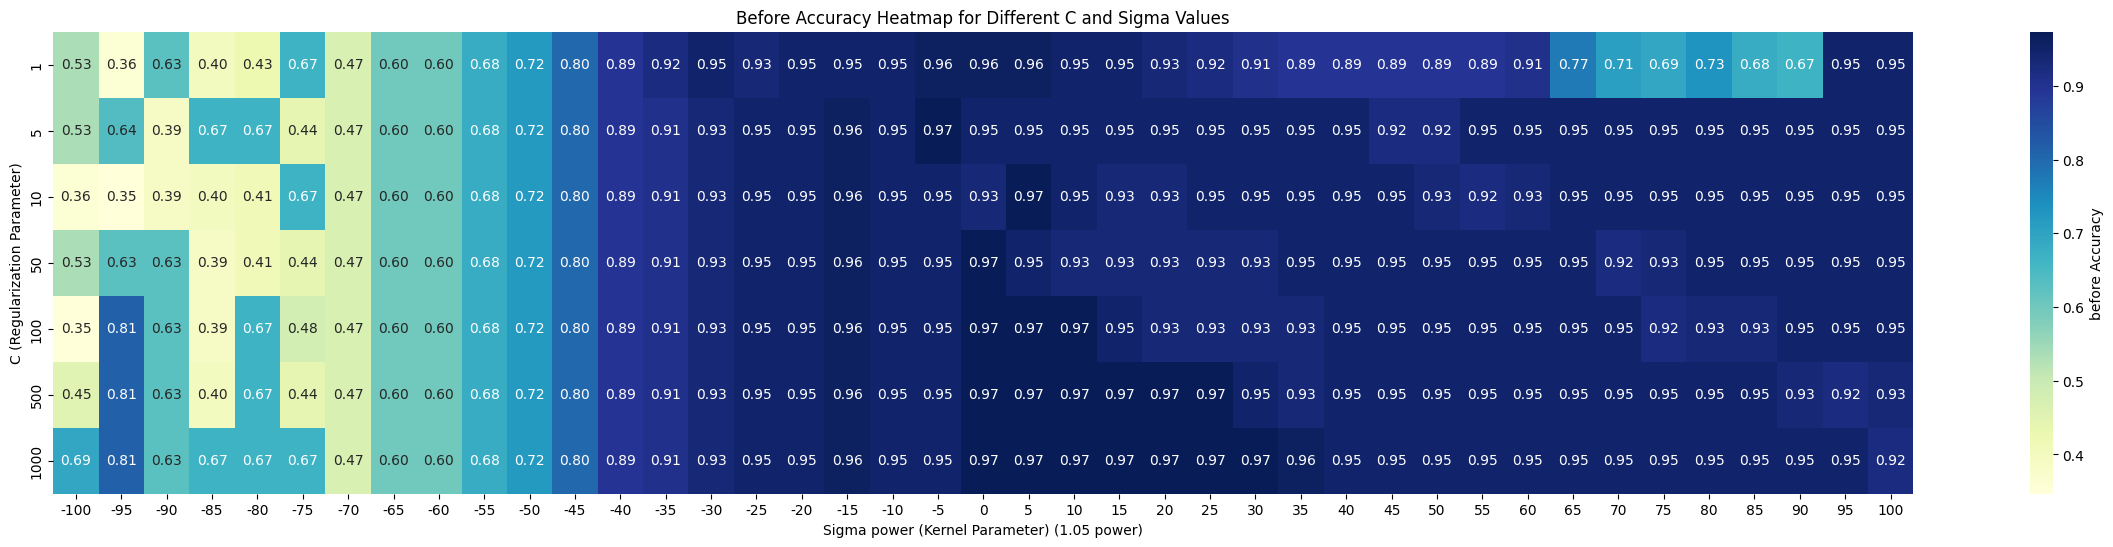

In [42]:
heatmap_data = result_record.pivot(index="C",columns="1.05 power", values="before_acc")

# 绘制热力图
plt.figure(figsize=(30, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'before Accuracy'})
plt.title("Before Accuracy Heatmap for Different C and Sigma Values")
plt.xlabel("Sigma power (Kernel Parameter) (1.05 power)")
plt.ylabel("C (Regularization Parameter)")
plt.show()

## Use After dataset

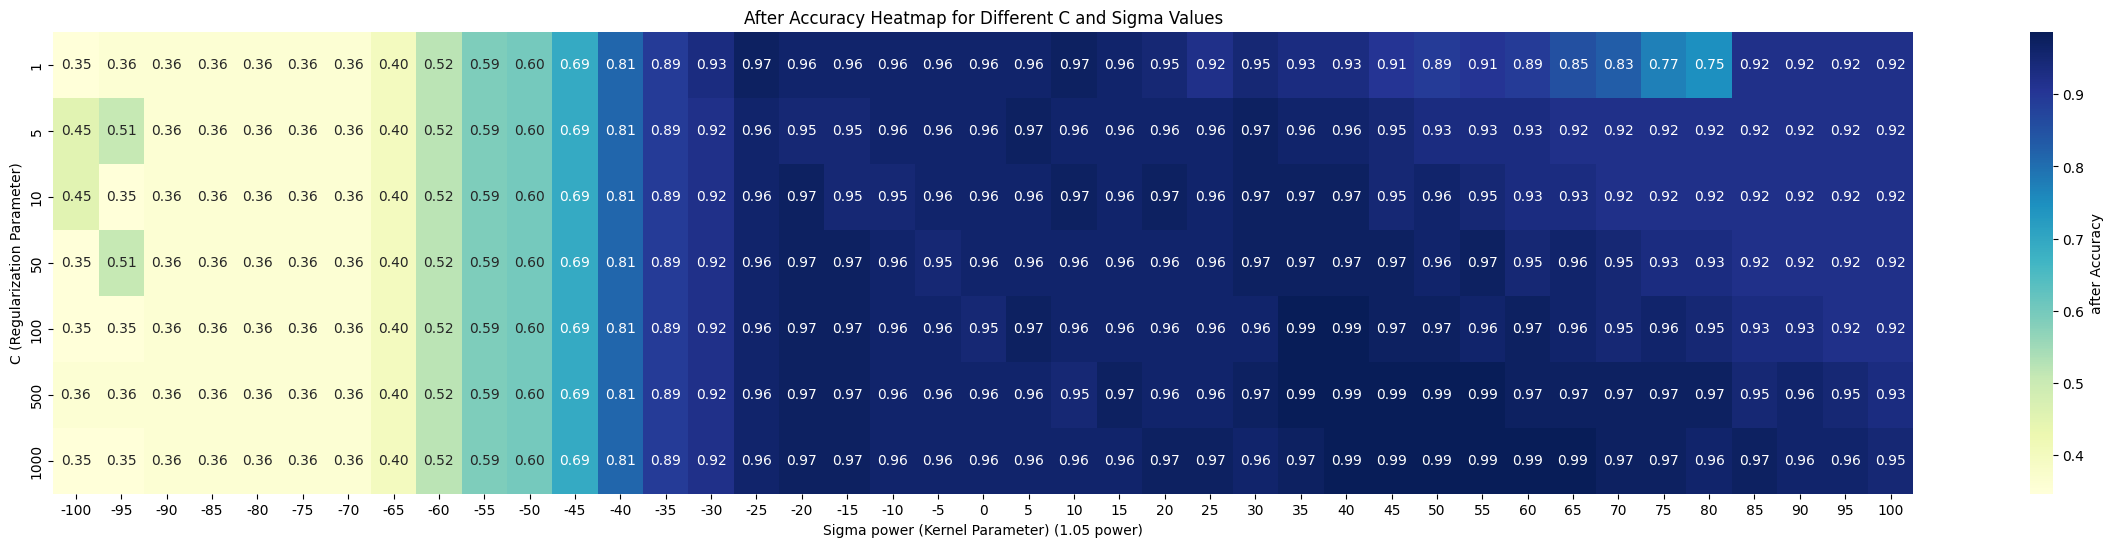

In [43]:
heatmap_data = result_record.pivot(index="C",columns="1.05 power", values="after_acc")

# 绘制热力图
plt.figure(figsize=(30, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'after Accuracy'})
plt.title("After Accuracy Heatmap for Different C and Sigma Values")
plt.xlabel("Sigma power (Kernel Parameter) (1.05 power)")
plt.ylabel("C (Regularization Parameter)")
plt.show()